In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

import pyblp
import numpy as np
import pandas as pd

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']


#create market data...
df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']

#add blp columns
df['prices'] = df['EHBPercentTotalPremium']
df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 
df['market_ids'] = df['County']
df['firm_ids'] = df['IssuerId']

#demand_instrument0
MktIds = np.array(pd.get_dummies(df['IssuerId']))
MktIds2 = (MktIds.T).dot(MktIds)
dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
df['demand_instruments0'] = dummies_proj.dot(df['prices']) #average price across markets


#fix problematic columns =
df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                  'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                       'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94'})

#create mkt share data
blp_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices','demand_instruments0']

nonlinear_cols = ['csr_pay_94']#,'SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']
#['act_value','csr_pay_94','csr_pay_87','SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']

linear_cols = [ 'act_value', 'MetalLevel_Silver','MetalLevel_Platinum','csr_tot']
#['CompositeRatingOffered_No','MetalLevel_Silver','MetalLevel_Platinum',
# 'BeginPrimaryCareCostSharingAfterNumberOfVisits' , 'csr_tot', 'csr_tot_94', 'PlanType_Indemnity']            
#'CSRVariationTypeBinary','DentalOnlyPlan_No','CompositeRatingOffered_No',

firm_cols =  linear_cols+ nonlinear_cols    
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE']
#mkt_cols = [ 'DP05_0015PE' ,'DP05_0072PE', 'DP03_0029PE','DP05_0069PE']


blp_data = df[blp_keys+linear_cols+nonlinear_cols+mkt_cols+['DP03_0095E']]


#standardize the cols
for col in firm_cols:
    #this line is causing a warning?
    blp_data[col] = blp_data[col]/blp_data[col].var()

#zero shares are not okay?
blp_data = blp_data[blp_data['shares']!=0]

<ipython-input-2-4afcbbfa3c1b>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blp_data[col] = blp_data[col]/blp_data[col].var()


In [3]:
#split into training and test
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(blp_data, blp_data, test_size=test_size)


def setup_blp(X_train):

    #set_up product/agent data
    product_data = X_train[blp_keys+linear_cols+nonlinear_cols+mkt_cols]
    product_data['market_ids'] = product_data['market_ids'].astype(str)

    #setup agent data
    agent_data = X_train[['market_ids']+ mkt_cols] #TODO CHANGE THIS for now cheat and add mkt cols
    agent_data = agent_data.groupby('market_ids',as_index=False).mean()
    agent_data['market_ids'] = agent_data['market_ids'].astype(str)
    return product_data,agent_data

product_data,agent_data = setup_blp(X_train)
product_data_test,agent_data_test = setup_blp(X_test)

<ipython-input-3-fe67115686f7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['market_ids'] = product_data['market_ids'].astype(str)


In [4]:
# do the estimation with just product characteristics?
X1_formula = ''
for i in (linear_cols+mkt_cols): #TODO CHANGE THIS for now cheat and add mkt cols
    X1_formula = X1_formula +  i + ' + '
X1_formula = '1 + prices + ' + X1_formula[:-3]

print(X1_formula)


X2_formula = ''
for i in nonlinear_cols:
    X2_formula = X2_formula + i + ' + '
X2_formula = '0 + prices + ' + X2_formula[:-3]


print(X2_formula)

X1_formulation = pyblp.Formulation(X1_formula)
X2_formulation = pyblp.Formulation(X2_formula)
product_formulations = (X1_formulation, X2_formulation)

1 + prices + act_value + MetalLevel_Silver + MetalLevel_Platinum + csr_tot + DP05_0015PE + DP05_0069PE
0 + prices + csr_pay_94


In [5]:
#numerical stuff
mc_integration = pyblp.Integration('monte_carlo', size=50, specification_options={'seed': 0})
mc_problem = pyblp.Problem(product_formulations, product_data, integration=mc_integration)
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-2})


#pi0 = np.zeros( (len(nonlinear_cols)+1,1) )
#sigma0 = np.ones((len(nonlinear_cols)+1, len(nonlinear_cols)+1))
sigma0 = np.eye(len(nonlinear_cols)+1)
beta0 = np.zeros( (len(nonlinear_cols)+1,1))

results1 = mc_problem.solve(sigma= sigma0,
                            optimization=bfgs)#,integration=mc_integration)
#TODO: Check if integration adds time?
results1

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +2.1E-18   +5.0E-09     -2.1E-02        +3.5E-03        0         +5.7E+11          +1.6E+20     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:01:08       Yes          0             4          4600         16520   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
  Sigma:      prices    csr_pay_94
----------  ----------  ----------
  prices     +1.0E+00             
            (+2.5E+00)            
                             

In [6]:
mc_integration = pyblp.Integration('monte_carlo', size=50, specification_options={'seed': 0})

sim_formulations = (X1_formulation, X2_formulation,
                    pyblp.Formulation('0 + demand_instruments0'))

xi = np.zeros(product_data_test.shape[0])

simulation = pyblp.Simulation(product_formulations,
   beta=results1.beta,
   sigma=results1.sigma,
   xi= xi,
   product_data=product_data_test,
   integration=mc_integration,
   seed=0,
)

sim_results = simulation.replace_endogenous(costs=xi,iteration=pyblp.Iteration('return'))
pred_shares = sim_results.product_data.shares

30678310.821543295


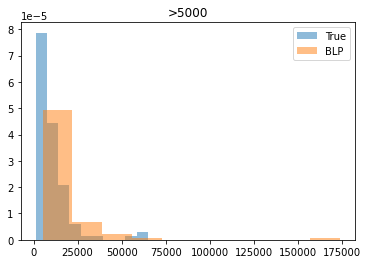

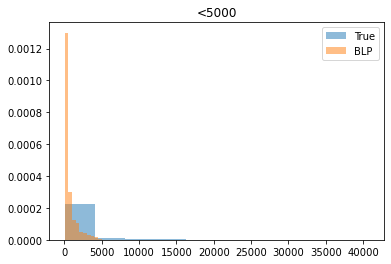

In [7]:
#evaluating model fit...
error = (X_test['shares']- pred_shares.flatten())*X_test['DP03_0095E']
print( (error**2).mean() )

blp_pred = pred_shares.flatten()*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']

split =5000
plt.title('>'+str(split))
plt.hist(blp_pred[true_shares >=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares >=split],label='BLP',alpha = .5,density=True)
plt.legend()
plt.show()


plt.title('<'+str(split))
plt.hist(blp_pred[true_shares <=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares <=split],label='BLP',alpha = .5,density=True)
plt.legend()
plt.show()

In [11]:
def report_error(X_test,pred_shares):
    pred_shares = np.array(pred_shares.copy()).flatten()
    X_test = X_test.copy()
    X_test['error'] =  ((X_test['shares']- pred_shares)*X_test['DP03_0095E'])**2
    X_test['pred'] = pred_shares*X_test['DP03_0095E']
    result = X_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('_x',''))
    result = result.sort_values('error',ascending=False).head(50) 
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

print(report_error(X_test,pred_shares))

               pred  Ever Enrolled Count      pred_var    enroll_var  count
State                                                                      
IL     29232.697772          2427.000000           NaN           NaN      1
AZ     26728.679592          9383.750000   8936.284738  13112.606146      8
FL     25615.369263         35091.307692  21176.350424  45007.599955     13
MI     17744.509495          1520.333333   3831.491016    923.805319      6
NJ     15245.730973          1977.333333   2842.097835   1344.137394      3
PA     14215.859970         22656.000000   4292.186811  21496.904265      3
OH     12753.733560          2658.000000           NaN           NaN      1
TX     12153.926559         23915.500000   4765.145843  23594.241533      6
MO     10619.738170         22955.000000           NaN           NaN      1
UT     10520.646303         16874.500000   2937.195399  22148.705707      2
NC      8635.894913         22278.000000    524.745740   3408.254685      2
VA      7311

# adding agents to the problem

In [9]:
#add agents to the problem?
agent_formula = ''
for i in mkt_cols:
    agent_formula = agent_formula + i + ' + '
agent_formula = '0 + ' + agent_formula[:-3]


agent_formulation = pyblp.Formulation(agent_formula)
agent_formulation


DP05_0015PE + DP05_0069PE

In [10]:
mc_integration = pyblp.Integration('monte_carlo', size=1, specification_options={'seed': 0})

full_problem = pyblp.Problem(
    product_formulations,
    product_data,
    agent_formulation,
    agent_data, 
    integration=mc_integration
)


bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-2})


#full_results = full_problem.solve(pi = np.eye(4), 
#                                  sigma=np.ones((len(nonlinear_cols)+1, len(nonlinear_cols)+1)),
#                                  optimization=bfgs)

#full_results